# Images segmentation

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
%matplotlib inline

### Algorithms

In [2]:
def compute_hist(img):
    """
    ---------
    Input
    img : numpy array (HxW)
    -------
    Output
    output: numpy array
        256d-array where the ith element corresponds to
        the number of pixels.
    """
    output = np.zeros(256, dtype=np.int32)
    for i in range(len(output)):
        output[i] = len(img[img==i])
    return output

## I. Image segmentation using histogram thresholding (Binarization)

### Goals

Study a simple evaluation method of a threshold for the image binarization from a random threshold

### Algorithm

1. Randomly chose a threshold S (between $0$ and $255$). Then assign intensities below S to group 1 and the others to group 2.

2. Compute the mean of each groups of pixels $S_{1}$ et $S_{2}$ using the split given by the histogramof the image.

3. Compute $S = \frac{S_{1}+S_{2}}{2}$

4. Repeat step 2 and 3 until S is constant.

### Work

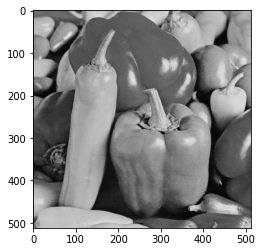

In [3]:
img = cv2.imread("./data/pepper.bmp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap=plt.cm.gray, vmin = 0, vmax = 255)
plt.show()

**1.** Compute the histogram of 'pepper.bmp'.

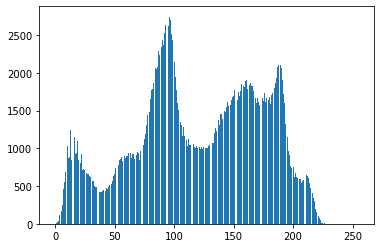

In [4]:
hist = compute_hist(img)
plt.bar(np.array([i for i in range(256)]), hist)
plt.show()

**2.** Implement the thresholding algorithm and verify its convergence.

In [5]:
def find_threshold(img):
    """
    """
    previous = -1
    threshold = np.random.randint(0, 255)
    n_iter = 0
    while previous!=threshold and n_iter < 100:
        previous = threshold
        pixels = np.sort(img.flatten())
        group1 = pixels[pixels < threshold]
        group2 = pixels[pixels >= threshold]

        s1 = group1.mean()
        s2 = group2.mean()

        threshold = (s1+s2)/2
        n_iter += 1

    return (threshold, n_iter)

In [6]:
np.random.seed(0)
threshold, n_iter = find_threshold(img)
print(f"Obtained threshold: {threshold:.05} in {n_iter} iterations.")

Obtained threshold: 120.05 in 7 iterations.


**3.** Apply image thresholding using two propositions:

* Proposition 1 : $Pixel(i,j)= \begin{cases} 0, & \mbox{if } Pixel(i,j) < S \\ 255, & \mbox{else.}\end{cases}$

* Proposition 2 : $Pixel(i,j)= \begin{cases} S_{1}, & \mbox{if } Pixel(i,j) < S \\ S_{2}, & \mbox{else.}\end{cases}$

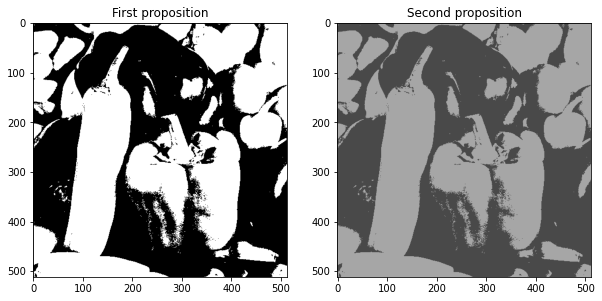

In [7]:
dst1 = img.copy()
dst2 = img.copy()

# 1st proposition
dst1[dst1 < threshold] = 0
dst1[dst1 >= threshold] = 255
# 2nd proposition
s1 = dst2[dst2 < threshold].mean()
s2 = dst2[dst2 >= threshold].mean()
dst2[dst2 < threshold] = s1
dst2[dst2 >= threshold] = s2

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title("First proposition")
axs[0].imshow(dst1, cmap=plt.cm.gray, vmin = 0, vmax = 255)
axs[1].set_title("Second proposition")
axs[1].imshow(dst2, cmap=plt.cm.gray, vmin = 0, vmax = 255)

plt.show()

## II. Images segmentation using K-means algorithm

### Goals

This project offers to segmentate an image using k-means algorithm.

### Algorithm

1. Choose a number of classes ($K$ classes).

2. Randomly choose means of these $K$ classes and store them in a growing vector.

3. Foreach intensity $i$ from $0$ to $255$ of the histogram, affect the class with the closest mean to this intensity $i$ :

$$
c(i)=min_{k \in [1,K]} (|i-m_{k}|) \\
\mbox{with } m_{k} \mbox{ mean } k^{th} \mbox{ class.}
$$

4. Compute the mean of each new class.

5. Repeat step 3 and 4 until the algorithm converges.

### Work

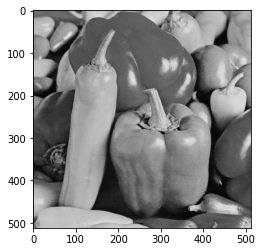

In [8]:
img = cv2.imread("./data/pepper.bmp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap=plt.cm.gray, vmin = 0, vmax = 255)

plt.show()

**1.** Compute the histogram of 'pepper.bmp'.

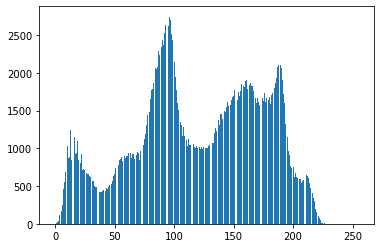

In [9]:
hist = compute_hist(img)
plt.bar(np.array([i for i in range(256)]), hist)
plt.show()

**2.** Implement the k-means algorithm and verify its convergence.

In [11]:
def kmeans(src, k):
    """ TODO
    """
    means = np.sort(np.rint((np.random.rand(k)*(src.max()-src.min())+ src.min())))
    previous = np.ones(k)-1
    n_iter = 0

    while not np.equal(previous, means).sum() or n_iter == 0:
        previous = np.copy(means)
        dst = src.copy()
        for i in range(k):
            # those boundaries assume that 'previous' array is sorted
            upper = max(previous[i:i+2].mean(), 255 if i==k-1 else 0)
            lower = min(1,i)*previous[max(i-1, 0):i+1].mean()

            group = dst[np.logical_and(lower<=dst,dst<=upper)]
            dst[np.logical_and(lower<=dst,dst<=upper)] = i

            if len(group)>0:
                means[i]=group.mean()
        # rounds means to integers
        means = np.rint(means)
        n_iter += 1
    
    return(dst, means, n_iter)


Obtained means: [ 49. 102. 151. 188.] in 4 iterations.


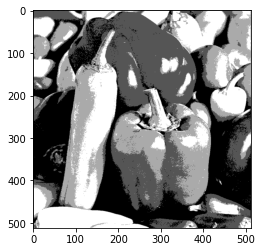

In [12]:
np.random.seed(0)
dst, means, n_iter = kmeans(img, 4)
print(f"Obtained means: {means} in {n_iter} iterations.")
plt.imshow(dst, cmap=plt.cm.gray)
plt.show()

**3.** Segmentate the image by affecting the mean of the class it belongs to each pixel. 

Execution lasted : 0.326s


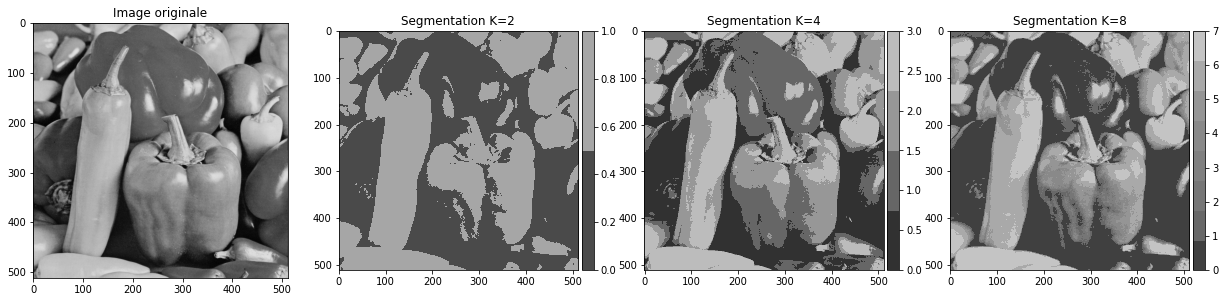

In [13]:
start = time.time()
fig, axs = plt.subplots(1, 4, figsize=(21,10))

axs[0].set_title("Image originale")
axs[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=255)

for n, k in enumerate([2, 4, 8]):
    np.random.seed(0)
    dst, means, n_iter = kmeans(img, k)
    colors = np.array([[value, value, value] for value in means])
    axs[n+1].set_title(f"Segmentation K={k}")
    cs = axs[n+1].imshow(dst, cmap=mlp.colors.ListedColormap(colors/255))

    divider = make_axes_locatable(axs[n+1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cs, cax=cax)

end = time.time()
print(f"Execution lasted : {end - start:.03}s")
plt.show()

## Advanced questions

**A.1** Image segmentation of COVID lungs with histogram and K-means

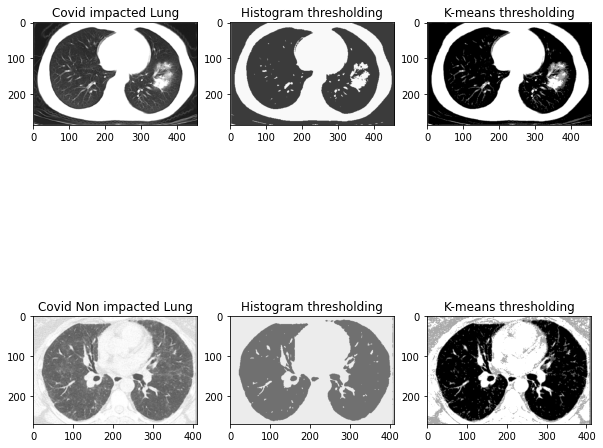

In [14]:
# Image

img_c = cv2.imread("./data/CT_COVID.png")
img_nc = cv2.imread("./data/CT_NonCOVID.jpg")

img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2GRAY)
img_nc = cv2.cvtColor(img_nc, cv2.COLOR_BGR2GRAY)

# Thresholding

np.random.seed(0)
threshold_c, n_iter_c = find_threshold(img_c)
dst1 = img_c.copy()
s1 = dst1[dst1 < threshold_c].mean()
s2 = dst1[dst1 >= threshold_c].mean()
dst1[dst1 < threshold_c] = s1
dst1[dst1 >= threshold_c] = s2

np.random.seed(0)
threshold_nc, n_iter_nc = find_threshold(img_nc)
dst2 = img_nc.copy()
s1 = dst2[dst2 < threshold_nc].mean()
s2 = dst2[dst2 >= threshold_nc].mean()
dst2[dst2 < threshold_nc] = s1
dst2[dst2 >= threshold_nc] = s2

# K-means

np.random.seed(0)
dst_c = img_c.copy()
dst_3, means_c, n_iter_c = kmeans(dst_c, 4)

np.random.seed(0)
dst_nc = img_nc.copy()
dst_4, means_nc, n_iter_nc = kmeans(dst_nc, 4)

# Display

fig, axs = plt.subplots(2, 3, figsize=(10, 10))

axs[0][0].set_title("Covid impacted Lung")
axs[0][0].imshow(img_c, cmap=plt.cm.gray, vmin = 0, vmax = 255)
axs[0][1].set_title("Histogram thresholding")
axs[0][1].imshow(dst1, cmap=plt.cm.gray, vmin = 0, vmax = 255)
axs[0][2].set_title("K-means thresholding")
axs[0][2].imshow(dst_3, cmap=plt.cm.gray)
axs[1][0].set_title("Covid Non impacted Lung")
axs[1][0].imshow(img_nc, cmap=plt.cm.gray, vmin = 0, vmax = 255)
axs[1][1].set_title("Histogram thresholding")
axs[1][1].imshow(dst2, cmap=plt.cm.gray, vmin = 0, vmax = 255)
axs[1][2].set_title("K-means thresholding")
axs[1][2].imshow(dst_4, cmap=plt.cm.gray)
plt.show()

**A.2.** Color images classification using K-means : modify the K-means algorithm to class a point cloud.

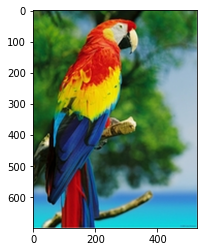

In [14]:
img = cv2.imread("./data/perroquet_couleur.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [15]:
def find_closest_mean(src, means):
    tmp = np.array([np.linalg.norm(src-mean, axis=2) for mean in means])
    
    output = np.argmin(tmp, axis=0)

    return output

In [16]:
def kmeans_color(src, k):
    """ TODO
    """
    mins = np.array([src[:, :, i].min() for i in range(3)])
    maxs = np.array([src[:, :, i].max() for i in range(3)])
    means = np.sort(np.rint((np.random.rand(k, 3) + mins)*maxs))
    previous = np.ones((k, 3))-1
    n_iter = 0
    
    while not np.equal(previous, means).sum() or n_iter == 0:
        previous = np.copy(means)

        for i in range(k):
            group = src[find_closest_mean(src, previous) == i]

            if len(group)>0:
                means[i]=np.mean(group, axis=0)

        # rounds means to integers
        means = np.rint(means)
        n_iter += 1
    
    return(means, n_iter)

Execution lasted : 45.7s


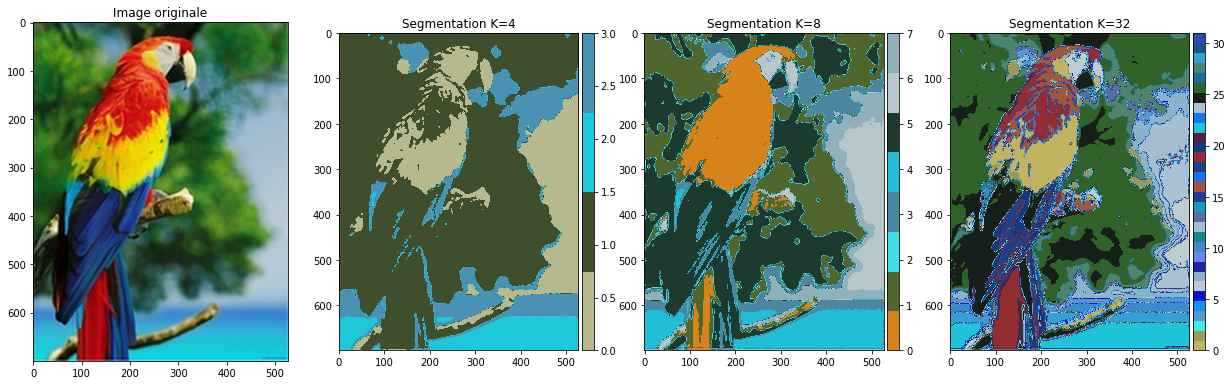

In [17]:
start = time.time()
fig, axs = plt.subplots(1, 4, figsize=(21, 10))

axs[0].set_title("Image originale")
axs[0].imshow(img)

for i, k in enumerate([4, 8, 32]):
    np.random.seed(0)
    means, n_iter = kmeans_color(img, k)
    # print(f"Obtained means:\n{means}\nin {n_iter} iterations.")
    dst = find_closest_mean(img, means)
    axs[i+1].set_title(f"Segmentation K={k}")
    cs = axs[i+1].imshow(dst, mlp.colors.ListedColormap(means/255))

    divider = make_axes_locatable(axs[i+1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cs, cax=cax)

end = time.time()
print(f"Execution lasted : {end - start:.03}s")
plt.show()